In [1]:
from lxml import html
import requests
import os
import pandas as pd
import glob
import subprocess
import seaborn as sns
import pandas as pd
from pprint import pprint
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%pylab inline

height has been deprecated.

Populating the interactive namespace from numpy and matplotlib


/Users/pschiffmann/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
ROOT_URL = "https://www.epcc.ed.ac.uk/msc/programmes/programme-structure/dissertation"
BASE_URL = "https://www.epcc.ed.ac.uk"
TARGET_DIR = "dissertations"

# Scraping dissertations

In [3]:
def get_dissertation_pages(root_url, base_url):
    page = requests.get(ROOT_URL)
    tree = html.fromstring(page.content)
    return [base_url + _.attrib["href"] for _ in tree.xpath(".//div/ul/li/a[contains(@href,'dissertation')]")]

In [4]:
dissertation_pages = get_dissertation_pages(ROOT_URL, BASE_URL)

In [5]:
def get_pdf_urls(dissertation_page, prefix="http://"):
    page = requests.get(dissertation_page)
    tree = html.fromstring(page.content)
    links = [prefix + _.attrib["href"][2:] for _ in tree.xpath(".//div/ul/li/a")]
    pdfs = [url for url in links if ".pdf" in url]
    return pdfs

In [6]:
urls = {}
for dp in dissertation_pages:
    year = dp.rsplit("/", 1)[1]
    urls[year] = get_pdf_urls(dp)
    print "{0}: {1} dissertation(s)".format(year, len(urls[year]))

2014-2015: 11 dissertation(s)
2013-2014: 17 dissertation(s)
2012-2013: 25 dissertation(s)
2011-2012: 21 dissertation(s)
2010-2011: 32 dissertation(s)
2009-2010: 19 dissertation(s)
2008-2009: 14 dissertation(s)
2007-2008: 22 dissertation(s)
2006-2007: 16 dissertation(s)
2005-2006: 17 dissertation(s)
2004-2005: 10 dissertation(s)
2003-2004: 9 dissertation(s)
2002-2003: 8 dissertation(s)
2001-2002: 2 dissertation(s)


In [7]:
def download_pdfs(urls, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
        
    for year in urls:
        print "Processing year {0}".format(year)
        
        year_dir = target_dir + os.sep + year
        if not os.path.exists(year_dir):
            os.makedirs(year_dir)
            
        for url in urls[year]:
            filename = url.rsplit("/", 1)[1]
            filepath = year_dir + os.sep + filename
            
            if not os.path.exists(filepath):
                print "Download {0}".format(filepath)
                
                r = requests.get(url)
                if r.status_code == 404:
                    print "ERROR 404: " + url
                else:
                    with open(filepath, "wb") as outfile:
                        outfile.write(r.content)

In [8]:
download_pdfs(urls, TARGET_DIR)

Processing year 2009-2010
Processing year 2002-2003
Download dissertations/2002-2003/2456009_12b-1.1.pdf
ERROR 404: http://static.ph.ed.ac.uk/dissertations/hpc-msc/2002-2003/2456009_12b-1.1.pdf
Processing year 2013-2014
Processing year 2005-2006
Processing year 2007-2008
Processing year 2014-2015
Processing year 2004-2005
Processing year 2003-2004
Processing year 2001-2002
Processing year 2011-2012
Processing year 2006-2007
Processing year 2010-2011
Processing year 2008-2009
Processing year 2012-2013


In [9]:
def pdf_to_txt(pdfpath):
    if not os.path.exists(pdfpath[:-4] + ".txt"):
        subprocess.call("pdftotext '" + pdfpath + "'", shell=True)
        print "CONVERTED: " + pdfpath
        
for pdf in glob.glob(TARGET_DIR + "/*/*.pdf"):
    pdf_to_txt(pdf)

# Analysis

## Dissertations per year

,count,mean,std,min,25%,50%,75%,max
0,14,15.928571,7.760494,2,10.25,16.5,20.5,32


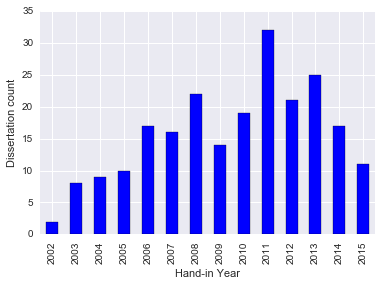

In [10]:
counts = {}
for year in sorted(urls):
    second_year = int(year.rsplit("-", 1)[1])
    counts[second_year] = len(urls[year])
df = pd.DataFrame(pd.Series(counts))
ax = df.plot(kind="bar", legend=None)
ax.set_xlabel("Hand-in Year")
ax.set_ylabel("Dissertation count")
df.describe().transpose()

## Length of dissertations

In [11]:
wordcounts = {}
for txt in glob.glob(TARGET_DIR + "/*/*.txt"):
    pdfname = txt[:-3] + "pdf"
    wc = int(subprocess.check_output("wc -w '" + txt + "'", shell=True).split()[0])
    pagecount = int(subprocess.check_output("pdfinfo '%s' | grep 'Pages:' | awk 'END {print $2}'" % pdfname, shell=True))
    wordcounts[txt] = {"wordcount": wc,
                       "pagecount": pagecount}

## Shortest and longest Dissertations

In [12]:
df = pd.DataFrame.from_dict(wordcounts, orient="index")
df["year"] = df.index.map(lambda x: x.split("/")[1])
print df.sort_values("wordcount").head()
print df.sort_values("wordcount", ascending=False).head()
print df.sort_values("pagecount").head()
print df.sort_values("pagecount", ascending=False).head()


                                                    wordcount  pagecount       year
dissertations/2010-2011/GuoYu.txt                        6374         34  2010-2011
dissertations/2010-2011/TadeuszJanowski.txt              8136         41  2010-2011
dissertations/2010-2011/JayChetty.txt                    9120         43  2010-2011
dissertations/2005-2006/2688821-9h-dissertation...       9495         39  2005-2006
dissertations/2005-2006/1533363-9c-dissertation...      10343         41  2005-2006
                                                    wordcount  pagecount       year
dissertations/2010-2011/IakovosPanourgias.txt           78685        110  2010-2011
dissertations/2007-2008/Peter_Alexander_Foster.txt      76831        183  2007-2008
dissertations/2006-2007/0773421-27d-d07rep1.3.txt       62011        150  2006-2007
dissertations/2009-2010/Daniel%20Wilde.txt              60725        153  2009-2010
dissertations/2011-2012/Submission-1065901.txt          49193        104  20

## Length over time

/Users/pschiffmann/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


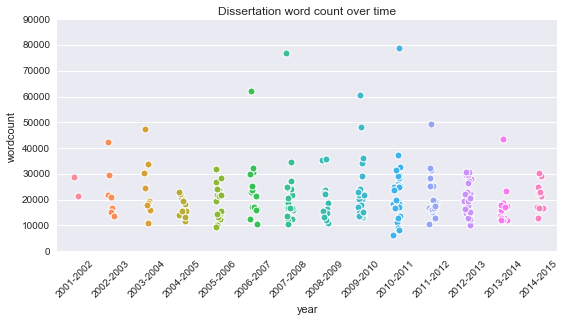

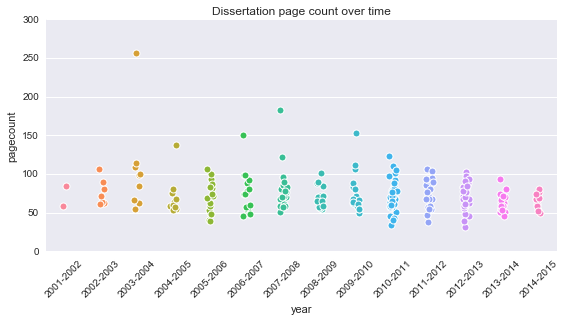

In [13]:
g = sns.factorplot(y="wordcount", x="year", data=df, kind="strip", aspect=2, jitter=True)
plt.title("Dissertation word count over time")
g.set_xticklabels(rotation=45)
# plt.axhline(y=15000) # recommendation 15k words

g = sns.factorplot(y="pagecount", x="year", data=df, kind="strip", aspect=2, jitter=True)
plt.title("Dissertation page count over time")
g.set_xticklabels(rotation=45)

## Dissertations possibly relevant to my project
Useful to choose the dissertations to review for project prep

In [14]:
# Dissertations possibly related to my project
words = "Proeme", "Nick Johnson", "Nicholas Johnson", "Visualisation"
for pdf in glob.glob(TARGET_DIR + "/*/*.txt"):
    with open(pdf, 'r') as fi:
        content = fi.read()
    for _ in words:
        if _ in content:
            print _, "\t", pdf
            break 

Visualisation 	dissertations/2002-2003/2453672_12b-1.1.txt
Visualisation 	dissertations/2004-2005/0762240-9j-dissertation1.1.txt
Visualisation 	dissertations/2005-2006/3365198-9a-dissertation1.3.txt
Visualisation 	dissertations/2006-2007/0459988.txt
Visualisation 	dissertations/2006-2007/6547365-27d-d07rep1.2.txt
Visualisation 	dissertations/2006-2007/Geraldine-McKenna.txt
Visualisation 	dissertations/2008-2009/Antonia_Collis.txt
Visualisation 	dissertations/2009-2010/Daniel%20Wilde.txt
Visualisation 	dissertations/2009-2010/Stefan%20Wysocki.txt
Visualisation 	dissertations/2010-2011/PaulRoss.txt
Visualisation 	dissertations/2010-2011/ThomasRichard.txt
Visualisation 	dissertations/2010-2011/VinodhVedachalam.txt
Visualisation 	dissertations/2011-2012/Submission-1147228.txt
Visualisation 	dissertations/2012-2013/Point%20Cloud%20Visualisation.txt
Visualisation 	dissertations/2012-2013/Visual%20Parallel%20Programming.txt
Visualisation 	dissertations/2013-2014/Accelerating Random Forest cla

## Relationship word-count to page-count

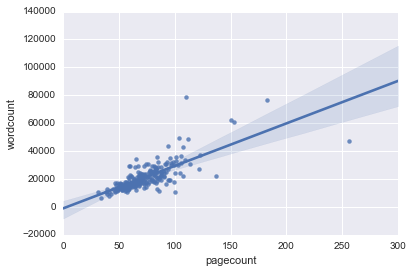

In [15]:
sns.regplot(x="pagecount", y="wordcount", data=df)

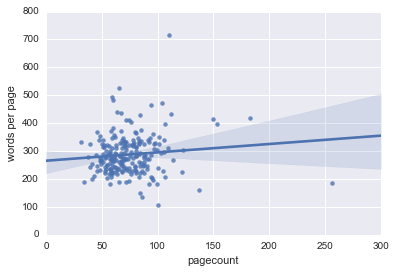

In [16]:
df["words per page"] = df.wordcount / df.pagecount
sns.regplot(x="pagecount", y="words per page", data=df)